In [1]:
import os
import numpy as np
import mne

# import matplotlib.pyplot as plt

# plt.ion()
%matplotlib inline

## Loading Data

MNE-Python data-structures are based around `FIF file format` from `Neuromag`.

EEG and MEG data from a subject performing an audiovisual experiment, along with MRI scans for that subject

In [2]:
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(
    sample_data_folder,
    'MEG',
    'sample',
    'sample_audvis_filt-0-40_raw.fif')

In [3]:
raw = mne.io.read_raw_fif(sample_data_raw_file)

Opening raw data file /home/mark/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Current compensation grade : 0


**SSP Projector:**
A projector (abbr. proj), also referred to as Signal Space Projection (SSP), defines a linear operation applied spatially to EEG or MEG data. You can see this as a matrix multiplication that reduces the rank of the data by projecting it to a lower dimensional subspace. Such a projection operator is applied to both the data and the forward operator for source localization. Note that EEG average referencing can be done using such a projection operator. It is stored in the measurement info in info['projs'].

[Background on projectors and projections](https://mne.tools/dev/auto_tutorials/intro/plot_40_projectors_background.html#tut-projectors-background)

In [4]:
print(raw)

<Raw  |  sample_audvis_filt-0-40_raw.fif, n_channels x n_times : 376 x 41700 (277.7 sec), ~3.6 MB, data not loaded>


In [5]:
print(raw.info)

<Info | 19 non-empty fields
    bads : list | MEG 2443, EEG 053
    ch_names : list | MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, ...
    chs : list | 376 items (GRAD: 204, MAG: 102, STIM: 9, EEG: 60, EOG: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    dig : list | 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
    events : list | 0 items
    file_id : dict | 4 items
    highpass : float | 0.10000000149011612 Hz
    hpi_meas : list | 1 items
    hpi_results : list | 1 items
    lowpass : float | 40.0 Hz
    meas_date : tuple | 2002-12-03 19:01:10 GMT
    meas_id : dict | 4 items
    nchan : int | 376
    proc_history : list | 0 items
    projs : list | PCA-v1: off, PCA-v2: off, PCA-v3: off, ...
    sfreq : float | 150.15374755859375 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    experimenter : NoneType
    gantry_angle : NoneType
   

Power Spectral Density (PSD) and raw traces for each sensor.
For the PSD plot, we'll only plot frequencies below 50 Hz – data is low-pass filtered at 40 Hz.

Effective window size : 13.639 (s)
Effective window size : 13.639 (s)
Effective window size : 13.639 (s)


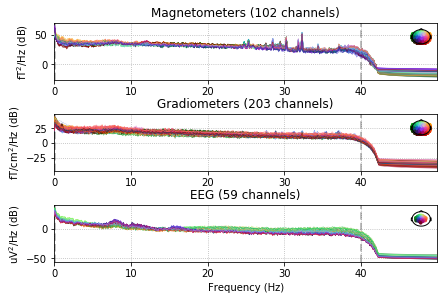

In [6]:
raw.plot_psd(fmax=50);

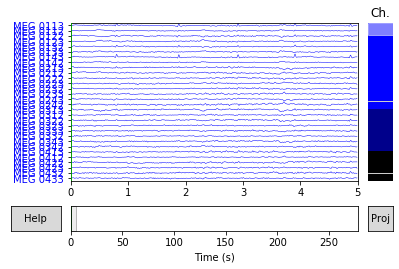

In [7]:
raw.plot(duration=5, n_channels=30);

## Preprocessing

Clean up data by performing independent component analysis (ICA). We'll skip the steps that helped determine which components that best capture the artifacts.
[Repairing artifacts with ICA](https://mne.tools/dev/auto_tutorials/preprocessing/plot_40_artifact_correction_ica.html#tut-artifact-ica)

In [8]:
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw)

Fitting ICA to data using 364 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 20 components
Fitting ICA took 1.4s.


<ICA  |  raw data decomposition, fit (fastica): 41700 samples, 20 components, channels used: "mag"; "grad"; "eeg">

In [9]:
ica.exclude = [1,2]

    Using multitaper spectrum estimation with 7 DPSS windows


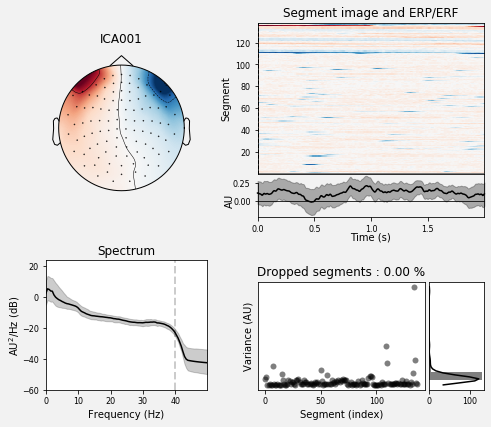

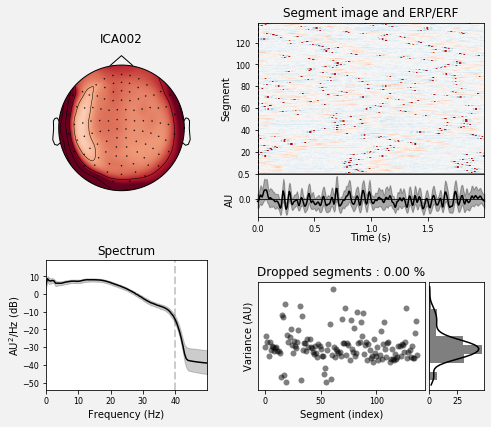

In [10]:
ica.plot_properties(raw, picks=ica.exclude);

In [11]:
orig_raw = raw.copy()
raw.load_data()

Reading 0 ... 41699  =      0.000 ...   277.709 secs...


<Raw  |  sample_audvis_filt-0-40_raw.fif, n_channels x n_times : 376 x 41700 (277.7 sec), ~123.3 MB, data loaded>

In [12]:
ica.apply(raw)

Transforming to ICA space (20 components)
Zeroing out 2 ICA components


<Raw  |  sample_audvis_filt-0-40_raw.fif, n_channels x n_times : 376 x 41700 (277.7 sec), ~123.3 MB, data loaded>

Show some frontal channels to clearly illustrate the artifact removal

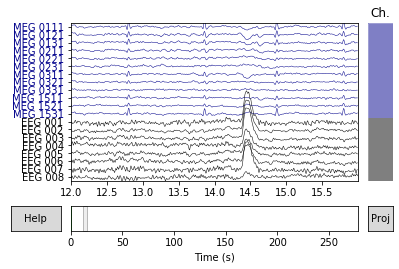

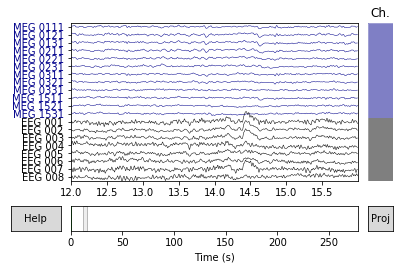

In [13]:
chs = ['MEG 0111', 'MEG 0121', 'MEG 0131', 'MEG 0211', 'MEG 0221', 'MEG 0231',
       'MEG 0311', 'MEG 0321', 'MEG 0331', 'MEG 1511', 'MEG 1521', 'MEG 1531',
       'EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006',
       'EEG 007', 'EEG 008']

chan_idxs = [raw.ch_names.index(ch) for ch in chs]
orig_raw.plot(order=chan_idxs, start=12, duration=4)
raw.plot(order=chan_idxs, start=12, duration=4);

## Detecting experimental events

In [14]:
events = mne.find_events(raw, stim_channel='STI 014')

319 events found
Event IDs: [ 1  2  3  4  5 32]


0: sample number
1: often ignored
2: event ID

In [15]:
print(events[:5])

[[6994    0    2]
 [7086    0    3]
 [7192    0    1]
 [7304    0    4]
 [7413    0    2]]


In [16]:
event_dict = {'auditory/left': 1, 'auditory/right': 2, 'visual/left': 3, 'visual/right': 4, 'smiley': 5, 'buttonpress': 32}

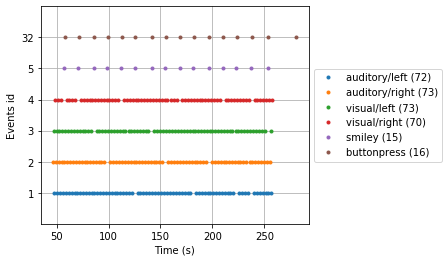

In [17]:
fig = mne.viz.plot_events(events, event_id=event_dict, sfreq=raw.info['sfreq']);

## Epoching continuous data

In [18]:
reject_criteria = dict(mag=4000e-15, # 4000 fT
                      grad=4000e-13, # 4000 fT/cm
                      eeg=150e-6, # 150 uV
                      eog=250e-6 # 250 uV
                      )

In [19]:
epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=-0.2, tmax=0.5, reject=reject_criteria, preload=True)

319 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Loading data for 319 events and 106 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EEG : ['EEG 008']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
10 bad epochs dropped


Pool across left/right stimulus presentations so we can compare auditory vs. visual responses. To avoid biasing signals to the left or right, we'll `equalize_event_counts` to randomly sample epochs from each condition to match the number of epochs present in the condition with the fewest good epochs.

In [20]:
conds_we_care_about = ['auditory/left', 'auditory/right', 'visual/left', 'visual/right']

In [21]:
epochs.equalize_event_counts(conds_we_care_about) # this operates in-place

Dropped 7 epochs


(<Epochs  |   302 events (all good), -0.199795 - 0.499488 sec, baseline [None, 0], ~95.5 MB, data loaded,
  'auditory/left': 68
  'auditory/right': 68
  'buttonpress': 16
  'smiley': 14
  'visual/left': 68
  'visual/right': 68>, array([273, 275, 121, 195, 258, 271, 274]))

In [22]:
aud_epochs = epochs['auditory']
vis_epochs = epochs['visual']

In [23]:
del raw, epochs # free up memory

Show each epoch as one row of an image map, with color representing signal magnitude; the avg. evoked response and the sensor location are shown below the image

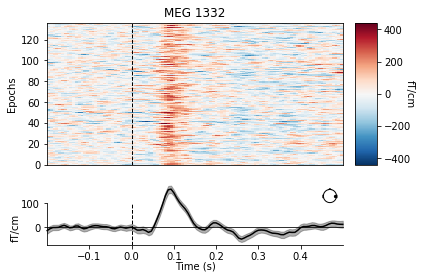

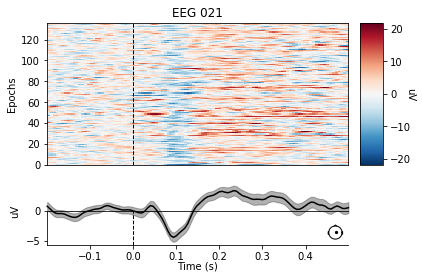

In [24]:
aud_epochs.plot_image(picks=['MEG 1332', 'EEG 021']);

## Time-frequency analysis

* time-frequency representations
* power spectral density
* cross-spectral density

For the auditory epochs compute the induced power at different frequencies  and times using `Morlet wavelets`

In [25]:
frequencies = np.arange(7, 30, 3)
power = mne.time_frequency.tfr_morlet(aud_epochs, n_cycles=2, return_itc=False, freqs=frequencies, decim=3)

No baseline correction applied


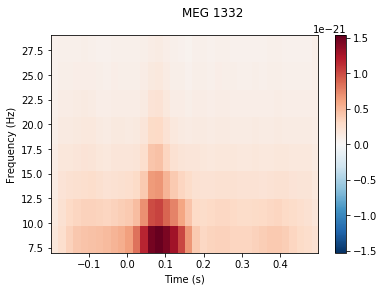

In [26]:
power.plot(['MEG 1332']);

## Estimating evoked responses

Get estimate of evoked responses to auditory versus visual stimuli by averaging together the epochs in each condition, 

In [27]:
aud_evoked = aud_epochs.average()
vis_evoked = vis_epochs.average()

No picks, plotting the GFP ...
Multiple channel types selected, returning one figure per type.


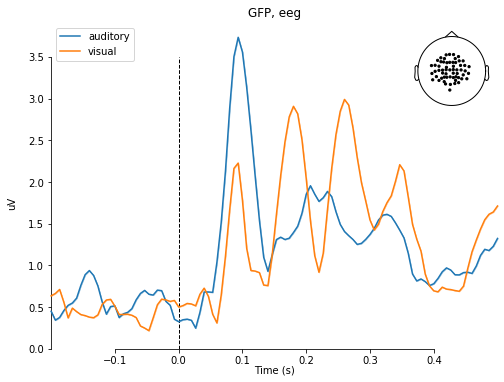

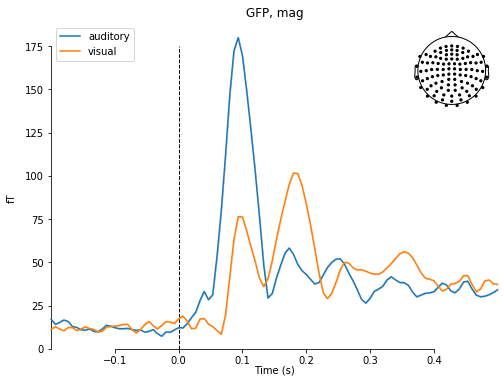

Combining all planar gradiometers with RMSE.


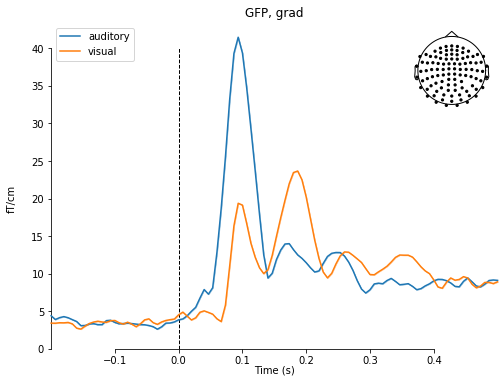

In [28]:
mne.viz.plot_compare_evokeds(dict(auditory=aud_evoked, visual=vis_evoked), show_legend='upper left', show_sensors='upper right');

Examining just the EEG channels, we'll see the classic auditory evoked N100-P200 pattern over dorso-frontal electrodes, the plot scalp topographies at some additional arbitrary times:

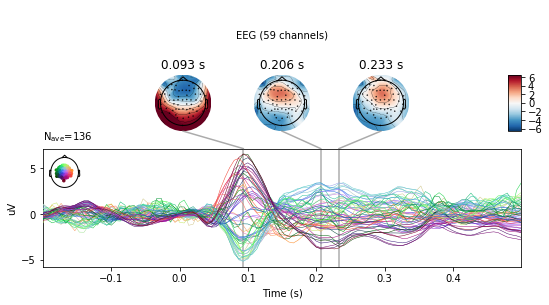

In [29]:
aud_evoked.plot_joint(picks='eeg');

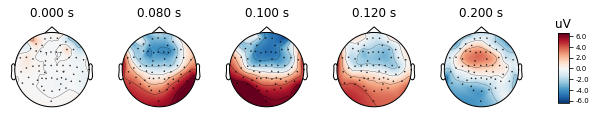

In [30]:
aud_evoked.plot_topomap(times=[0., 0.08, 0.1, 0.12, 0.2], ch_type='eeg');

Combining evoked responses to show contrast betwen conditions. Plot the difference wave at each sensor:

In [31]:
evoked_diff = mne.combine_evoked([aud_evoked, -vis_evoked], weights='equal')

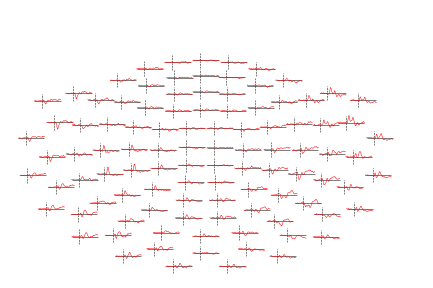

In [32]:
evoked_diff.pick_types('mag').plot_topo(color='r', legend=False);

## Inverse modeling

Estimating the origins of the evoked activity by projecting the sensor data into the subject's `source space`. Here we'll use a minimum-norm estimation (MNE) to generate a continous map of activation contrained to the cortical surface. 
MNE uses a linear `inverse operator` to project EEG+MEG sensor measurements into the source space. The inverse operator is computed from the `forward solution` for this subject and estimate of `the covariance of sensor measurements`

In [33]:
# load inverse operator
inverse_operator_file = os.path.join(sample_data_folder, 'MEG', 'sample', 'sample_audvis-meg-oct-6-meg-inv.fif')
inverse_operator = mne.minimum_norm.read_inverse_operator(inverse_operator_file)

# set SNR to compute regularization parameter (λ²)
snr = 3.
lambda2 = 1. / snr ** 2

# generate the source time course (STC)
stc = mne.minimum_norm.apply_inverse(vis_evoked, inverse_operator, lambda2=lambda2, method='MNE')

Reading inverse operator decomposition from /home/mark/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    305 x 305 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Noise covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 2) found.
    Source covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 6) found.
    Orientation priors read.
    22494 x 22494 diagonal covariance (kind = 5) found.
    Depth priors read.
    Did not find the desired covariance matrix (kind = 3)
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patc

In [34]:
# path to subjects' MRI files
# subjects_dir = os.path.join(sample_data_folder, 'subjects')
# stc.plot(initial_time=0.1, hemi='split', views=['lat', 'med'], subjects_dir=subjects_dir);